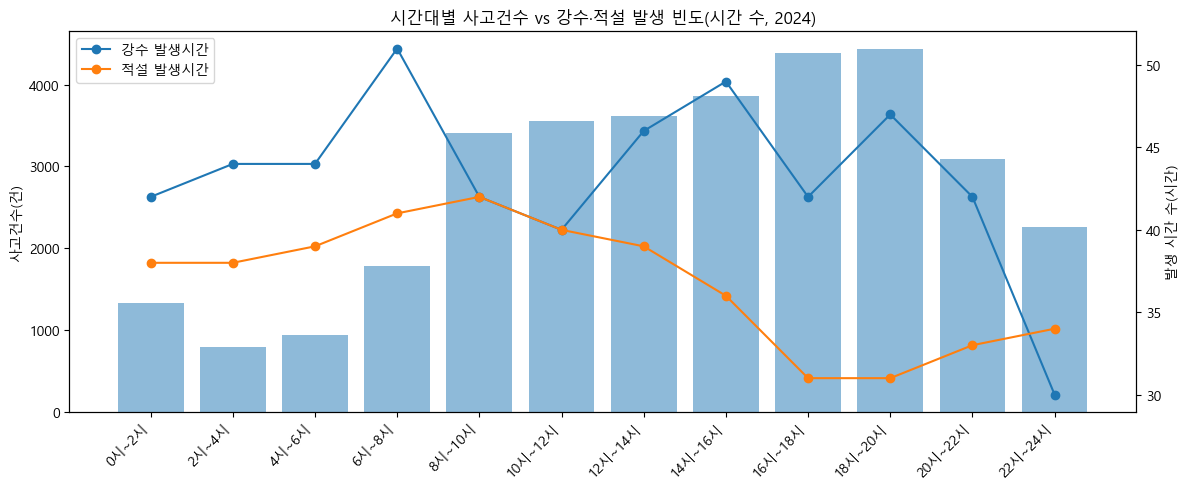

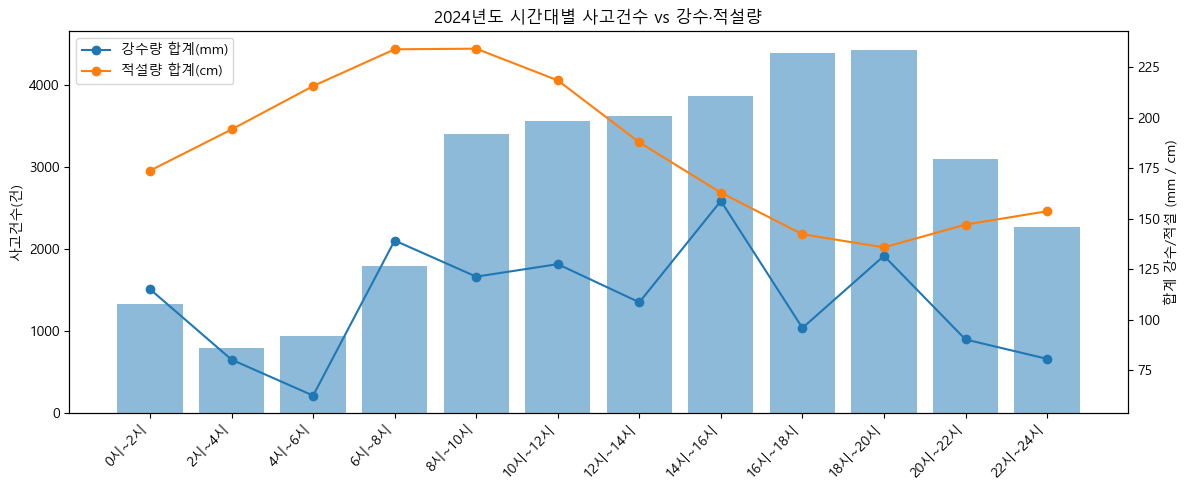

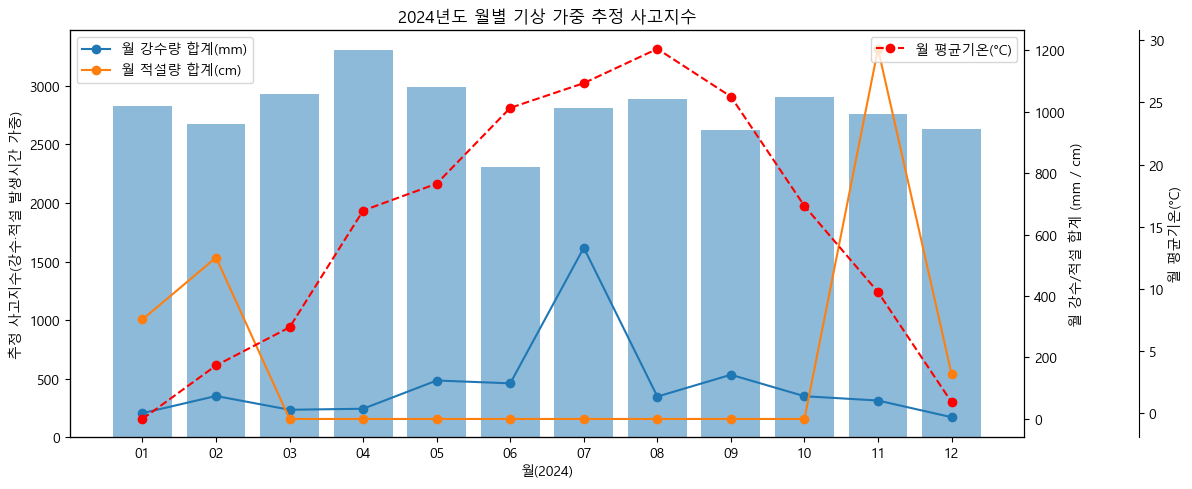

,시간대,사고건수,avg_temp,total_rain,total_snow,rain_hours,snow_hours
0,0시~2시,1329,13.234426,115.1,173.8,42,38
1,2시~4시,792,12.580191,80.2,194.2,44,38
2,4시~6시,938,12.038525,62.4,215.7,44,39
3,6시~8시,1789,11.735929,139.2,233.9,51,41
4,8시~10시,3403,12.969536,121.3,234.2,42,42
5,10시~12시,3559,15.523907,127.5,218.5,40,40
6,12시~14시,3620,17.597951,108.6,187.8,46,39
7,14시~16시,3861,18.644126,158.8,162.9,49,36
8,16시~18시,4389,18.356557,95.9,142.3,42,31
9,18시~20시,4430,16.682923,131.6,135.8,47,31


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib import font_manager as fm


TIME_ACC_PATH = "./time_accident.csv"
WEATHER_PATH  = "./timedata.csv"

# 1) 폰트 설정
preferred_fonts = ["Malgun Gothic"]
available = {f.name for f in fm.fontManager.ttflist}
for f in preferred_fonts:
    if f in available:
        plt.rcParams["font.family"] = f
        break
plt.rcParams["axes.unicode_minus"] = False

# 시간대 라벨("0시~2시")에서 시작 시각(0)을 추출해 정렬에 활용
# ex) "10시~12시" -> 10, "22시~24시" -> 22
def start_hour(label: str) -> int:
    m = re.match(r"(\d+)시~", str(label))
    return int(m.group(1)) if m else 999


# 2) 사고(시간대별, 연간 집계) 전처리
df_time_raw = pd.read_csv(TIME_ACC_PATH, encoding="cp949")

header_row = df_time_raw.iloc[0].to_dict()
rename_map = {}
for c in df_time_raw.columns:
    if c in ["시도", "연도"]:
        rename_map[c] = c
    else:
        rename_map[c] = str(header_row.get(c, c)).strip()

df_time = df_time_raw.rename(columns=rename_map).iloc[1:].copy()

# 텍스트 정리, 서울의 사고[건]만 추출
# 공백이 있으면 필터링이 실패할 수 있으므로 strip() 적용
df_time["시도"] = df_time["시도"].astype(str).str.strip()
df_time["연도"] = df_time["연도"].astype(str).str.strip()

df_time_seoul = df_time[(df_time["시도"] == "서울") & (df_time["연도"] == "사고[건]")].copy()

# 시간대 컬럼만 추출 후 시간 순서대로 정렬
# "합계" 같은 컬럼은 제외하고 "시~" 패턴이 있는 것만 사용
time_band_cols = [c for c in df_time_seoul.columns if re.search(r"시~", str(c))]
time_band_cols = sorted(time_band_cols, key=start_hour)

# 각 행이 하나의 시간대를 의미하도록 변환
# : [시간대, 사고건수] 형태로 만듦
df_acc_band = df_time_seoul.melt(
    id_vars=["시도"],
    value_vars=time_band_cols,
    var_name="시간대",
    value_name="사고건수"
)
df_acc_band["사고건수"] = (
    df_acc_band["사고건수"]
    .astype(str).str.replace(",", "", regex=False).str.strip()
    .replace({"": np.nan})
    .astype(float).astype("Int64")
)
df_acc_band = df_acc_band[["시간대", "사고건수"]].copy()
df_acc_band["sort_key"] = df_acc_band["시간대"].apply(start_hour)
df_acc_band = df_acc_band.sort_values("sort_key").drop(columns=["sort_key"]).reset_index(drop=True)


# 3) 날씨 전처리(시간별) -> 2시간 주기, 월 파생

# 필요 컬럼 선정 및 rename
df_w_raw = pd.read_csv(WEATHER_PATH, encoding="cp949")
need_cols = ['일시', '기온(°C)', '강수량(mm)', '습도(%)', '적설(cm)']
df_w = df_w_raw[need_cols].rename(columns={
    '일시': 'datetime',
    '기온(°C)': 'temp_avg',
    '강수량(mm)': 'rain_mm',
    '습도(%)': 'humidity_pct',
    '적설(cm)': 'snow_cm'
}).copy()

# 결측치 처리
df_w["rain_mm"] = df_w["rain_mm"].fillna(0)
df_w["snow_cm"] = df_w["snow_cm"].fillna(0)

# 수치형 변환
for c in ["temp_avg", "rain_mm", "humidity_pct", "snow_cm"]:
    df_w[c] = pd.to_numeric(df_w[c], errors="coerce")

# 날짜형 변환
df_w["datetime"] = pd.to_datetime(df_w["datetime"], errors="coerce")
df_w = df_w.dropna(subset=["datetime"])

df_w = df_w[(df_w["datetime"] >= "2024-01-01") & (df_w["datetime"] < "2025-01-01")].copy()
df_w["month"] = df_w["datetime"].dt.month
df_w["hour"] = df_w["datetime"].dt.hour

# 2시간 주기 구간 생성
# 앞 숫자가 시작 번호를 나타냄
df_w["band_start"] = (df_w["hour"] // 2) * 2
df_w["시간대"] = df_w["band_start"].apply(lambda h: f"{h}시~{h+2}시" if h < 22 else "22시~24시")


# 4) 연간(시간대별) 날씨 요약
# 빈도: rain_hours, snow_hours (비/눈이 관측된 '시간' 수)
# 강수량: total_rain(mm 합계), total_snow(cm 합계)
# avg_temp: 시간대 평균 기온

df_w_band_annual = (
    df_w.groupby("시간대", as_index=False)
      .agg(
          avg_temp=("temp_avg", "mean"),
          total_rain=("rain_mm", "sum"),
          total_snow=("snow_cm", "sum"),
          rain_hours=("rain_mm", lambda s: int((s > 0).sum())),
          snow_hours=("snow_cm", lambda s: int((s > 0).sum())),
      )
)

# 시간 순서대로 정렬
df_w_band_annual["sort_key"] = df_w_band_annual["시간대"].apply(start_hour)
df_w_band_annual = df_w_band_annual.sort_values("sort_key").drop(columns=["sort_key"]).reset_index(drop=True)

# 시간 별 날씨,사고 데이터 병합
df_band = df_acc_band.merge(df_w_band_annual, on="시간대", how="left")

# 5) 월별(기상) 가중 사고지수(추정) :월 템플릿(df_w_month,df_w_month_band)으로 누락 방지
df_w_month = (
    df_w.groupby("month", as_index=False)
      .agg(
          avg_temp=("temp_avg", "mean"),
          total_rain=("rain_mm", "sum"),
          total_snow=("snow_cm", "sum"),
          rain_hours=("rain_mm", lambda s: int((s > 0).sum())),
          snow_hours=("snow_cm", lambda s: int((s > 0).sum()))
      )
)

# 월 시간대별 강수/적설 '발생시간(노출)' 계산
# precip_hours = rain_hours + snow_hours
# 이후 연간 사고건수와 결합하여 월별 가중지수 산출
df_w_month_band = (
    df_w.groupby(["month", "시간대"], as_index=False)
      .agg(
          rain_hours=("rain_mm", lambda s: int((s > 0).sum())),
          snow_hours=("snow_cm", lambda s: int((s > 0).sum()))
      )
).merge(df_acc_band, on="시간대", how="left")

df_w_month_band["precip_hours"] = df_w_month_band["rain_hours"] + df_w_month_band["snow_hours"]

# 월별 weighted_index 계산
# 분모: 해당 월의 전체 precip_hours 합, 분자: Σ(시간대별 사고건수 * 해당 월/시간대 precip_hours)
# precip_hours가 0이면 해당 월은 비/눈 노출이 없으므로 weighted_index는 NaN 처리
month_vals = []
for m, g in df_w_month_band.groupby("month"):
    ph = float(g["precip_hours"].sum())
    if ph > 0:
        wi = float((g["사고건수"].astype(float) * g["precip_hours"]).sum() / ph)
    else:
        wi = np.nan
    month_vals.append((m, ph, wi))

df_month_index = pd.DataFrame(month_vals, columns=["month", "precip_hours", "weighted_index"])

# 월 템플릿(1~12)로 누락 원천 차단
month_template = pd.DataFrame({"month": list(range(1, 13))})
df_month = (
    month_template
    .merge(df_w_month, on="month", how="left")
    .merge(df_month_index, on="month", how="left")
    .sort_values("month")
    .reset_index(drop=True)
)

# 표시용 결측 보정
# 강수/적설/시간수: 없으면 0(해당 달 관측/집계가 없거나 0이라는 의미)
# 평균 기온: 그래프에서 선이 끊기지 않도록
# weighted_index: 비/눈 노출이 0인 달은 0으로 표시, no_precip_flag로 표시 가능

for c in ["total_rain", "total_snow", "rain_hours", "snow_hours", "precip_hours"]:
    df_month[c] = df_month[c].fillna(0)

df_month["avg_temp"] = df_month["avg_temp"].interpolate(limit_direction="both")

df_month["no_precip_flag"] = df_month["weighted_index"].isna().astype(int)
df_month["weighted_index"] = df_month["weighted_index"].fillna(0)

df_month["month_label"] = df_month["month"].apply(lambda m: f"{int(m):02d}")

# 6) 그래프 출력

# (1) 시간대별 사고건수 vs 강수&적설 발생 빈도
fig = plt.figure(figsize=(12, 5))
ax1 = plt.gca()
ax1.bar(df_band["시간대"], df_band["사고건수"],alpha= 0.5)
ax1.set_ylabel("사고건수(건)")
ax1.set_title("시간대별 사고건수 vs 강수·적설 발생 빈도(시간 수, 2024)")
ax1.set_xticks(range(len(df_band)))
ax1.set_xticklabels(df_band["시간대"], rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(range(len(df_band)), df_band["rain_hours"], marker="o")
ax2.plot(range(len(df_band)), df_band["snow_hours"], marker="o")
ax2.set_ylabel("발생 시간 수(시간)")
ax2.legend(["강수 발생시간", "적설 발생시간"], loc="upper left")

plt.tight_layout()
plt.show()

# (2) 시간대별 사고건수 vs 강수/적설 '량'(합계)
fig = plt.figure(figsize=(12, 5))
ax1 = plt.gca()
ax1.bar(df_band["시간대"], df_band["사고건수"],alpha= 0.5)
ax1.set_ylabel("사고건수(건)")
ax1.set_title("2024년도 시간대별 사고건수 vs 강수·적설량")
ax1.set_xticks(range(len(df_band)))
ax1.set_xticklabels(df_band["시간대"], rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(range(len(df_band)), df_band["total_rain"], marker="o")
ax2.plot(range(len(df_band)), df_band["total_snow"], marker="o")
ax2.set_ylabel("합계 강수/적설 (mm / cm)")
ax2.legend(["강수량 합계(mm)", "적설량 합계(cm)"], loc="upper left")

plt.tight_layout()
plt.show()

# (마지막) 월별 조건 그래프: 3축으로 '안 보임/누락 오해' 해결
fig = plt.figure(figsize=(12, 5))
ax1 = plt.gca()

ax1.bar(df_month["month_label"], df_month["weighted_index"],alpha = 0.5)
ax1.set_ylabel("추정 사고지수(강수·적설 발생시간 가중)")
ax1.set_xlabel("월(2024)")
ax1.set_title("2024년도 월별 기상 가중 추정 사고지수")

# y2: 강수/적설
ax2 = ax1.twinx()
ax2.plot(df_month["month_label"], df_month["total_rain"], marker="o")
ax2.plot(df_month["month_label"], df_month["total_snow"], marker="o")
ax2.set_ylabel("월 강수/적설 합계 (mm / cm)")
ax2.legend(["월 강수량 합계(mm)", "월 적설량 합계(cm)"], loc="upper left")

# y3: 기온 (축 분리)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.12))
ax3.plot(df_month["month_label"], df_month["avg_temp"], marker="o", linestyle="--",color = 'red')
ax3.set_ylabel("월 평균기온(°C)")
ax3.legend(["월 평균기온(°C)"], loc="upper right")

# 강수·적설이 0시간인 달 표기(있으면)
for i, r in df_month.iterrows():
    if int(r["no_precip_flag"]) == 1:
        ax1.text(i, r["weighted_index"], "no\nprecip", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

# 월별 테이블 확인
df_month
df_band

In [14]:
# csv로 저장
df_month.to_csv("monthly_weather_accident.csv", index=False)